In [1]:
import numpy as np
import torch

from train import EGBADTrainer
from preprocess import get_mnist

In [2]:
class Args:
    num_epochs=100
    lr=1e-4
    latent_dim=256
    anormal_class=1
    batch_size=128
    pretrained=False
    
    
args = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = get_mnist(args)

egbad = EGBADTrainer(args, data, device)

In [3]:
egbad.train()

42606/42606: [===============================>] - ETA 0.3sss
Training... Epoch: 0, Discrimiantor Loss: 0.158, Generator Loss: 13.776
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 1, Discrimiantor Loss: 0.234, Generator Loss: 11.356
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 2, Discrimiantor Loss: 0.287, Generator Loss: 10.251
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 3, Discrimiantor Loss: 0.486, Generator Loss: 6.838
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 4, Discrimiantor Loss: 0.693, Generator Loss: 4.730
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 5, Discrimiantor Loss: 0.672, Generator Loss: 4.954
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 6, Discrimiantor Loss: 0.744, Generator Loss: 4.419
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 

42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 62, Discrimiantor Loss: 0.996, Generator Loss: 3.458
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 63, Discrimiantor Loss: 1.002, Generator Loss: 3.424
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 64, Discrimiantor Loss: 0.983, Generator Loss: 3.505
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 65, Discrimiantor Loss: 0.995, Generator Loss: 3.442
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 66, Discrimiantor Loss: 0.988, Generator Loss: 3.465
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 67, Discrimiantor Loss: 0.970, Generator Loss: 3.522
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoch: 68, Discrimiantor Loss: 0.988, Generator Loss: 3.471
42606/42606: [===============================>] - ETA 0.0ss
Training... Epoc

In [4]:
from torch.autograd import Variable
import torch.nn.functional as F


alpha = 0.9
labels = []
scores = []

egbad.G.eval()
egbad.D.eval()

with torch.no_grad():
    for img, label in data[1]:
        img = img.float().to(device)
        img_hat = egbad.G(egbad.E(img))
        score_g = torch.sum(torch.abs(img - img_hat), dim=(1,2,3))
        
        y_true = Variable(torch.ones((img.size(0), 1)).to(device))
        y_pred = egbad.D(img, egbad.E(img)).view(-1)
        score_d = F.binary_cross_entropy(y_pred, y_true)
        
        score = alpha * score_g + (1-alpha)* score_d
        scores.append(score.cpu())
        labels.append(label.cpu())

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])) is deprecated. Please ensure they have the same size.
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Using a target size (torch.Size([114, 1])) that is different to the input size (torch.Size([114])) is deprecated. Please ensure they have the same size.


In [5]:
scores = torch.cat(scores, dim=0)
labels = torch.cat(labels, dim=0)

In [6]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc

precision, recall, thresholds = precision_recall_curve(labels, scores)

print('ROC AUC score: {:.2f}'.format(roc_auc_score(labels, scores)*100))
print('PR AUC score: {:.2f}'.format(auc(recall, precision)*100))

ROC AUC score: 38.86
PR AUC score: 30.84


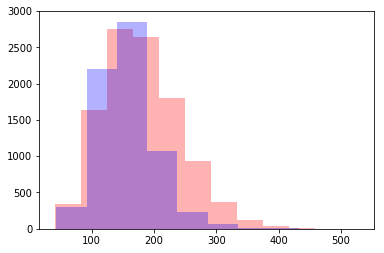

In [8]:
import matplotlib.pyplot as plt

plt.hist(scores[labels==0], color='r', alpha = 0.3)
plt.hist(scores[labels==1], color='b', alpha=0.3)
plt.show()